In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df_dnm = pd.read_csv("aau1043_dnm.tsv")
df_parental_age = pd.read_csv("aau1043_parental_age.tsv")

In [4]:
df_dnm

,Chr,Pos,Ref,Alt,Proband_id,Phase_combined,Crossover,Sanger
0,chr1,241097646,C,T,99379,father,paternal_crossover,confirmed
1,chr10,29202943,A,G,8147,father,maternal_crossover,PCR failed
2,chr11,129441657,C,T,5410,mother,maternal_crossover,confirmed
3,chr13,96867147,A,G,46025,father,paternal_crossover,confirmed
4,chr17,50609998,C,T,144769,mother,maternal_crossover,confirmed
...,...,...,...,...,...,...,...,...
26426,chr9,137374330,C,T,54383,father,NaN,NaN
26427,chr9,137396508,C,T,39729,father,NaN,NaN
26428,chr9,137633973,C,A,17904,mother,NaN,NaN
26429,chr9,137889777,G,A,80108,father,NaN,NaN


In [5]:
df_parental_age

,Proband_id,Father_age,Mother_age
0,675,31,36
1,1097,19,19
2,1230,30,28
3,1481,32,20
4,1806,38,34
...,...,...,...
391,153657,27,23
392,154565,36,30
393,154621,19,18
394,154810,32,28


In [21]:
proband_count = {}

for row in df_dnm.itertuples():
    proband_id = row[5]
    phase_combined = row[6]
    
    proband_count.setdefault(proband_id, [0,0,0])
    
    proband_count[proband_id][2] += 1
    
    if phase_combined == "father":
        proband_count[proband_id][0] += 1
    elif phase_combined == "mother":
        proband_count[proband_id][1] += 1

In [27]:
df_dnm_count = pd.DataFrame(columns = ["Proband_id", "pat_dnm", "mat_dnm", "tot_dnm"])
for proband_id, counts in proband_count.items():
    df_dnm_count = df_dnm_count.append({
        "Proband_id": proband_id,
        "pat_dnm": counts[0],
        "mat_dnm": counts[1],
        "tot_dnm": counts[2]
    }, ignore_index=True)
    
df_dnm_count

,Proband_id,pat_dnm,mat_dnm,tot_dnm
0,99379,38,8,47
1,8147,78,27,114
2,5410,52,16,70
3,46025,40,11,52
4,144769,49,13,63
...,...,...,...,...
391,36485,44,7,51
392,19715,40,9,52
393,131854,48,7,58
394,67028,31,7,38


In [82]:
df_dnm_age = df_parental_age.merge(df_dnm_count)
df_dnm_age = df_dnm_age.astype({
    'pat_dnm': 'int64',
    'mat_dnm': 'int64',
    'tot_dnm': 'int64'
})
df_dnm_age

,Proband_id,Father_age,Mother_age,pat_dnm,mat_dnm,tot_dnm
0,675,31,36,51,19,70
1,1097,19,19,26,12,39
2,1230,30,28,42,12,57
3,1481,32,20,53,14,68
4,1806,38,34,61,11,78
...,...,...,...,...,...,...
391,153657,27,23,41,8,49
392,154565,36,30,61,14,75
393,154621,19,18,39,11,50
394,154810,32,28,55,14,69


In [87]:
xp = df_dnm_age.loc[:,"Father_age"][1:]
yp = df_dnm_age.loc[:,"pat_dnm"][1:]

xm = df_dnm_age.loc[:,"Mother_age"][1:]
ym = df_dnm_age.loc[:,"mat_dnm"][1:]

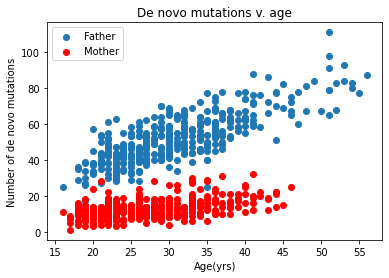

In [88]:
fig, ax = plt.subplots()
ax.scatter(xp, yp, label="Father")
ax.scatter(xm, ym, color="red", label="Mother")

ax.set_title("De novo mutations v. age")
ax.set_xlabel("Age(yrs)")
ax.set_ylabel("Number of de novo mutations")
ax.legend()

In [89]:
mat_model = smf.ols(formula = "mat_dnm ~ 1 + Mother_age", data = df_dnm_age)
mat_results = mat_model.fit()
mat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mat_dnm   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     116.0
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           6.88e-24
Time:                        18:17:13   Log-Likelihood:                -1158.1
No. Observations:                 396   AIC:                             2320.
Df Residuals:                     394   BIC:                             2328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5040      0.981      2.553      0.011       0.576       4.432
Mother_age     0.3776      0.035     10.772      0.000       0.309       0.446
==============================================================================
Omnibus:                       51.143   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.501
Skew:                           0.845   Prob(JB):                     4.03e-17
Kurtosis:                       4.310   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The relationship mat_dnm v. Mother_age is significant (p-val<0.05)

In [85]:
pat_model = smf.ols(formula = "pat_dnm ~ 1 + Father_age", data = df_dnm_age)
pat_results = pat_model.fit()
pat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pat_dnm   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     639.6
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           1.55e-84
Time:                        18:15:33   Log-Likelihood:                -1406.6
No. Observations:                 396   AIC:                             2817.
Df Residuals:                     394   BIC:                             2825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3263      1.702      6.066      0.000       6.979      13.673
Father_age     1.3538      0.054     25.291      0.000       1.249       1.459
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.185
Skew:                           0.256   Prob(JB):                       0.0167
Kurtosis:                       3.483   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
pat_results.pvalues

Intercept     3.079437e-09
Father_age    1.552294e-84
dtype: float64

The relationship pat_dnm v. Father_age is significant (pval<0.001)

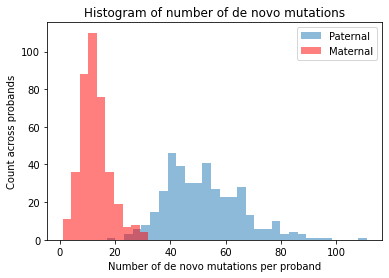

In [96]:
fig,ax = plt.subplots()
ax.hist(yp, alpha = 0.5, label = "Paternal", bins = 30)
ax.hist(ym, color = "red", alpha = 0.5, label = "Maternal")

ax.set_title("Histogram of number of de novo mutations")
ax.set_xlabel("Number of de novo mutations per proband")
ax.set_ylabel("Count across probands")
ax.legend()

plt.show()

In [95]:
stats.ttest_ind(yp, ym)

Ttest_indResult(statistic=53.30597513071407, pvalue=1.435337370692767e-263)

Difference in number of de novo mutations per proband maternally and paternally inherited is significant (p-val<0.01) 